# Homework 3: Monte Carlo

In this assignment you will implement off-policy every-visit Monte Carlo Control and off-policy every-visit Monte Carlo Control with Weighted Importance Sampling. You will apply both of these algorithms on the frozen lake and blackjack environments and visualize their performance.

In [1]:
import gym

In [2]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from collections import defaultdict

from gym.envs.toy_text.frozen_lake import FrozenLakeEnv
from gym.envs.toy_text.blackjack import BlackjackEnv
plt.style.use('ggplot')

### Setup the Environment

This assignment introduces you to two environments derived from OpenAI gym: the frozen lake environment
and the blackjack environment. Frozen lake is a grid world where the agent must reach a goal state while
avoiding holes. You can get the full description of frozen lake [here](https://gym.openai.com/envs/FrozenLake-v0/) or by looking at frozen lake.py in
your code directory. The other environment is in blackjack.py. This implements the same version of
blackjack described in Example 5.1 in [SB](http://incompleteideas.net/book/the-book-2nd.html).

In [3]:
blackjack_env = BlackjackEnv()
frozen_lake_env = FrozenLakeEnv(desc=None, map_name="4x4",is_slippery=False)

### Exercise 1 (5 pts):

Implement e-greedy action selection based on the current Q-values. Break ties between equal Q-values uniformly randomly. Remeber an action should be a number in the range: [0, num_actions].

In [5]:
q_curr=[1,2,3,4]
for i in range(len(q_curr)):
    print i

0
1
2
3


In [21]:
np.random.randint(4)

1

In [6]:
def whetherAllzero(q_curr):
    for i in range(len(q_curr)):
        if q_curr[i]!=0:
            return False
            break
        elif i==len(q_curr)-1:
            return True
        else:
            continue
   

In [22]:
def eGreedyActionSelection(q_curr, eps):
    if np.random.rand()<eps:
        return np.random.randint(len(q_curr))
    else:
        if whetherAllzero(q_curr):
            return np.random.randint(len(q_curr))
        else:
            list_q_curr = q_curr.tolist()
            max_index = list_q_curr.index(max(list_q_curr))
            return max_index
    
    '''
    Preforms epsilon greedy action selectoin based on the Q-values.
    
    Args:
        q_curr: A numpy array that contains the Q-values for each action for a state.
        eps: The probability to select a random action. Float between 0 and 1.
        
    Returns:
        The selected action.
    '''

### Exercise 2 (10 pts):

Implement the off-policy every-visit Monte Carlo update using the incremental update formula in Section 2.4 in SB. Recall that in Chapter 2 we averaged the *rewards* whereas in MC we average the *returns*. In the formula below $G_n$ denotes the return at timestep $n$.

$$
\begin{align}
    Q_{n+1} = Q_n + \alpha [G_n - Q_n]
\end{align}
$$

In [29]:
def updateMCValues(Q_func, episode_transitions, gamma, alpha):
    value=[]
    return_val=0
    for item in reversed(episode_transitions):
        return_val=return_val*gamma+item[2]
        value.append((item[0],item[1],return_val))
    for item in reversed(value):
        Q_func[item[0]][item[1]]+=alpha*(item[2]-Q_func[item[0]][item[1]])
    '''
    Updates the Q-function according to the given episode transitions.
    
    Args:
        Q_func: A dictonary mapping state -> action values.
        episode_transitions: A list of (state, action, reward) tuples describing the episode.
        gamma: The discount factor.
        alpha: The stepsize.
        
    Returns:
        The updated Q-function.
    '''
    
    return Q_func

### Exercise 3 (5 pts):

Add code just after the commented line, ```YOUR CODE HERE to display E-GREEDY ACTION SELECTION```, that prints the state, action, next state, reward, done flag information to
the screen for each transition experienced. Display actions using the corresponding English words. For
frozenlake, display state as an integer. For blackjack, display state as the set of cards expressed in English.
Turn in these two transition sequences as an answer to this question.

In [30]:
def train_mc_agent(env, num_episodes, eps=0.1, gamma=1.0, alpha=0.1, logging=True):
    '''
    Trains a off-policy every-visit MC agent.
    
    Args:
        env: The environment to train the agent on.
        num_episodes: The number of episodes to train the agent for.
        eps: The probability to select a random action. Float between 0 and 1.      
        gamma: The discount factor.
        alpha: The stepsize.
        logging: Boolean flag which turns logging off/on.
        
    Returns:
        A tuple: (Q_func, episode_rewards)
        Q_func is a dictonary mapping state -> action values.
        episode_rewards is a list containing the rewards obtained for each episode during training.
    '''
    
    # Create Q function dict with default values
    init_q_value = 0.0
    Q_func = defaultdict(lambda: np.ones(env.action_space.n) * init_q_value)
    
    episode_rewards = [0.0]
    pbar = tqdm.trange(num_episodes-1) if logging else range(num_episodes-1)
    for curr_episode in pbar: 
        episode_transitions = list()
        state = env.reset()
        is_done = False
        while not is_done:
            # Get the next action and execute it
            action = eGreedyActionSelection(Q_func[state], eps)
            new_state, reward, is_done, _ = env.step(action)
            episode_transitions.append((state, action, reward))
            
            if logging:
                if env==frozen_lake_env:
                    print 'state:',state
                    if  action==0:
                        print 'action: left'
                    elif action==1:
                        print 'action: down'
                    elif action==2:
                        print 'action: right'
                    elif action==3:
                        print 'action: up'
                        print 'next state:',new_state
                    print 'reward:',reward
                    if is_done:
                        print 'end'
                    else:
                        print'continue'
                elif env==blackjack_env:
                    print 'obs_playerSum:',state[0],'obs_dealerSum:',state[1],'whether_usableAce:',state[2]
                        
                    if action==0:
                        print 'action: stick'
                    elif action==1:
                        print 'action: twist'
                    print 'next_playerSum:',new_state[0],'next_dealerSum:',new_state[1],'next_usableAce:',new_state[2]
                    print 'reward:',reward
                    if is_done:
                        print 'end'
                    else:
                        print'continue'
                    
                    
                # **** YOUR CODE HERE to display E-GREEDY ACTION SELECTION ****
                # Display experienced obs, action, new_obs, rew, done tuples.
                pass

            state = new_state

        # Update the Q function
        Q_func = updateMCValues(Q_func, episode_transitions, gamma, alpha)   
        # Bookkeeping: store episode rewards to measure performance.
        episode_rewards[-1] += reward
        episode_rewards.append(0.0)
        mean_100ep_reward = round(np.mean(episode_rewards[-51:-1]), 1)
        if logging:
            pbar.set_description('Mean Reward: {}'.format(mean_100ep_reward))
            
    return Q_func, episode_rewards

### Exercise 4 (10 pts):

Calculate a learning curve averaged over 50 runs for step size parameter, α = 0.1. The learning curve should plot average reward per episode as a function of episode number, starting with the first episode and going up to 50k episodes. Plot the resulting learning curve for both the frozen lake environment and the blackjack environment.

In [31]:
def list_add(a,b):
    c = []
    for i in range(len(a)):
        c.append(a[i]+b[i])
    return c


In [32]:
def plotLearningCurve(env,  episode_numbers):
    rewards_iter=[0 for _ in range(episode_numbers)]
    for run_numbers in range(0,50):
        Q_func,episode_rewards=train_mc_agent(env, episode_numbers, eps=0.1, gamma=1.0, alpha=0.1, logging=False)
        rewards=episode_rewards
        stored_reward=rewards[0]
        for episode_num in range(episode_numbers):       
            rewards[episode_num]=stored_reward+(1.0/(episode_num+1))*(rewards[episode_num]-stored_reward)
            stored_reward=rewards[episode_num]
        rewards_iter=list_add(rewards_iter, rewards)
    rewards_avg = [c/50 for c in rewards_iter]
    episode_num_plot= np.array(range(1,episode_numbers+1))
    rewards_avg_plot= np.array(rewards_avg)
    plt.plot(episode_num_plot,rewards_avg_plot,color='green',linestyle='--',marker='s',markersize=1,label='learning curve')



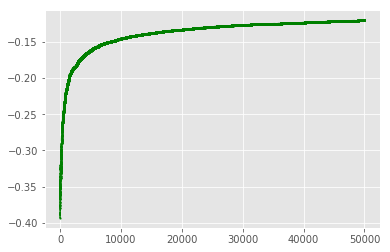

In [34]:
plotLearningCurve(blackjack_env,  50000)

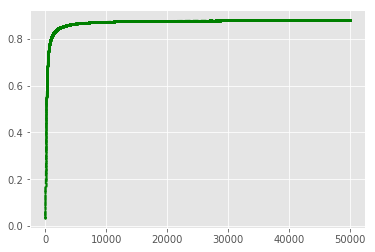

In [33]:
plotLearningCurve(frozen_lake_env,50000)

### Exercise 5 (10 pts):

Run your code up to 500k episodes for the blackjack domain with a step size parameter that enables the value function to converge. Plot the value 'function as a color plot with a similar layout to that shown in SB Figure 5.1. Make sure you include the color bar or some kind of key that indicates the values of the colors. Also plot the learned blackjack policy, showing something similar to that shown in SB Figure 5.2. It’s okay if your policy is slightly different from what they get, but please explain why this is. You may need to adjust α to ensure convergence.

In [37]:
from mpl_toolkits.mplot3d import Axes3D

In [38]:
def plot_value_function(V, title="Value Function"):
    """
    Plots the value function as a surface plot.
    """
    min_x = min(k[0] for k in V.keys())
    max_x = max(k[0] for k in V.keys())
    min_y = min(k[1] for k in V.keys())
    max_y = max(k[1] for k in V.keys())

    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)

    # Find value for all (x, y) coordinates
    Z_noace = np.apply_along_axis(lambda _: V[(_[0], _[1], False)], 2, np.dstack([X, Y]))
    Z_ace = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))

    def plot_surface(X, Y, Z, title):
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                               cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player Sum')
        ax.set_ylabel('Dealer Showing')
        ax.set_zlabel('Value')
        ax.set_title(title)
        ax.view_init(ax.elev, -120)
        fig.colorbar(surf)
        plt.show()

    plot_surface(X, Y, Z_noace, "{} (No Usable Ace)".format(title))
    plot_surface(X, Y, Z_ace, "{} (Usable Ace)".format(title))

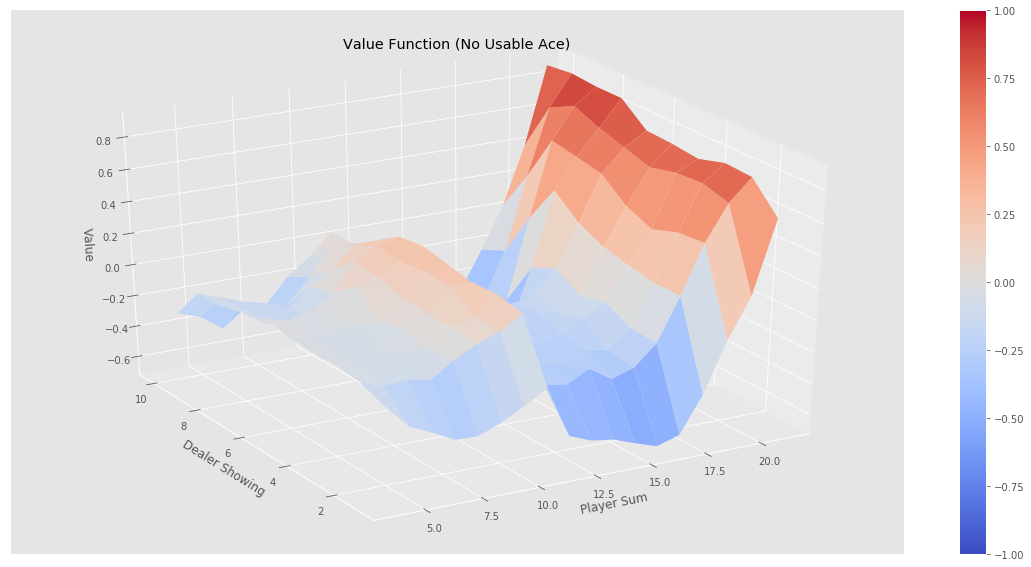

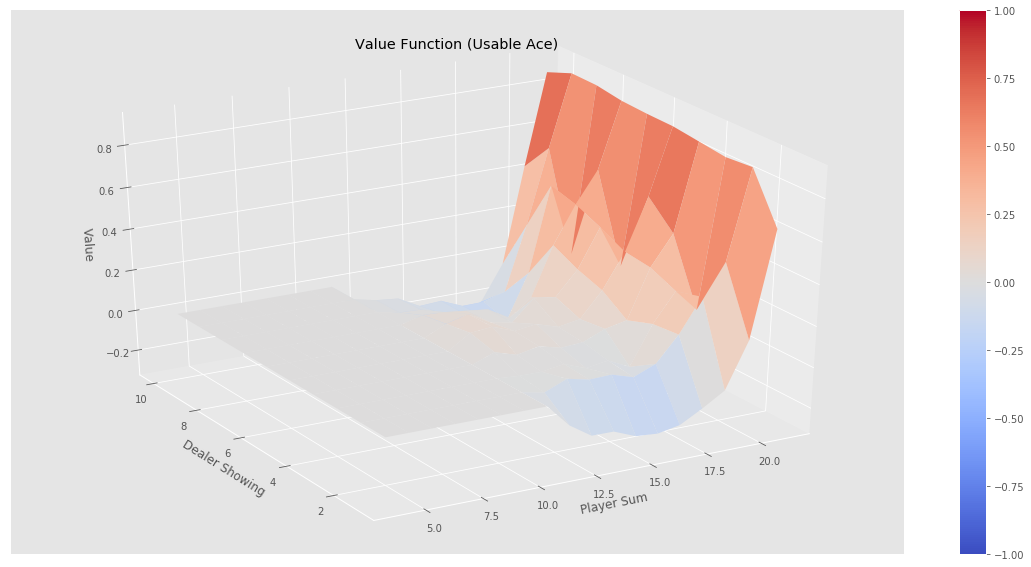

In [39]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
Q_func,episode_rewards=train_mc_agent(blackjack_env, 500000, eps=0.1, gamma=1.0, alpha=0.002, logging=False)
for state, actions in Q_func.items():
    action_value = np.max(actions)
    V[state] = action_value
# plotting.plot_value_function(V, title="Optimal Value Function")
plot_value_function(V, title="Value Function")

In [40]:
def plotPolicy(Q_func):
    # Plot BlackJack Greedy Policy for Q

    # create numpy arrays for usable and non-usable ace cases
    X_noace = np.zeros((22,11))
    X_usable = np.zeros((22,11))
    for key,value in Q_func.items():
        if key[2] == False:
            X_noace[key[0],key[1]] = np.argmax(value)
        else:
            X_usable[key[0],key[1]] = np.argmax(value)

    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches
    #plot non-usable ace case
    fig, ax = plt.subplots()
    ax.imshow(X_noace, interpolation='nearest')

    numrows, numcols = X_noace.shape
    plt.ylim(12,21)
    plt.xlim(1,10)
    plt.xlabel('Dealer Hand')
    plt.ylabel('Player Hand')
    plt.title('BlackJack MC Policy - No Usable Ace')

    yellow_patch = mpatches.Patch(color='yellow', label='Hit')
    purple_patch = mpatches.Patch(color='indigo', label='Stand/Stick')
    plt.legend(handles=[yellow_patch, purple_patch])

    def format_coord(x, y):
        col = int(x + 0.5)
        row = int(y + 0.5)
        if col >= 0 and col < numcols and row >= 0 and row < numrows:
            z = X[row, col]
            return 'x=%1.4f, y=%1.4f, z=%1.4f' % (x, y, z)
        else:
            return 'x=%1.4f, y=%1.4f' % (x, y)

    ax.format_coord = format_coord
    plt.show()

    #plot usable ace case
    _ , ax = plt.subplots()
    ax.imshow(X_usable, interpolation='nearest')
    plt.ylim(12,21)
    plt.xlim(1,10)
    plt.xlabel('Dealer Hand')
    plt.ylabel('Player Hand')
    yellow_patch = mpatches.Patch(color='yellow', label='Hit')
    purple_patch = mpatches.Patch(color='indigo', label='Stand/Stick')
    plt.legend(handles=[yellow_patch, purple_patch])
    numrows, numcols = X_noace.shape
    plt.title('BlackJack MC Policy - Usable Ace')
    plt.show()

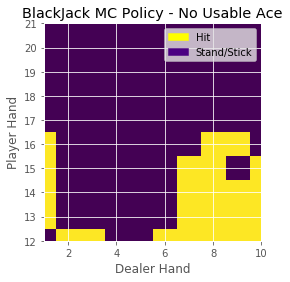

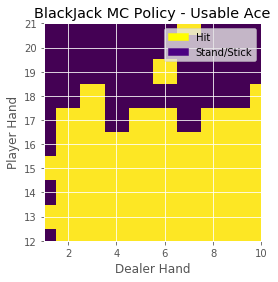

In [41]:
Q_func,episode_rewards=train_mc_agent(blackjack_env, 500000, eps=0.1, gamma=1.0, alpha=0.002, logging=False)
plotPolicy(Q_func)

### Exercise 6 (20 pts):

Implement the below function to train a off-policy every-visit MC agent which uses weighted importance sampling. As before it should use epsilon greedy action selection. Feel free to reuse any code from above.

In [78]:
def create_greedy_policy(Q):
    def policy_fn(state):
        A = np.zeros_like(Q[state], dtype=float)
        best_action = np.argmax(Q[state])
        A[best_action] = 1.0
        return A
    return policy_fn

In [79]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [80]:
def train_mc_agent_importance_sampling(env, num_episodes, eps=0.1, gamma=1.0, alpha=0.1, logging=True):
    '''
    Trains a off-policy every-visit MC agent with weighted importance sampling.
    
    Args:
        env: The environment to train the agent on.
        num_episodes: The number of episodes to train the agent for.
        eps: The probability to select a random action. Float between 0 and 1.      
        gamma: The discount factor.
        alpha: The stepsize.
        logging: Boolean flag which turns logging off/on.
        
    Returns:
        A tuple: (Q_func, episode_rewards)
        Q_func is a dictonary mapping state -> action values.
        episode_rewards is a list containing the rewards obtained for each episode during training.
    '''
    init_q_value = 0.0
    Q_func = defaultdict(lambda: np.ones(env.action_space.n) * init_q_value)
    episode_rewards = [0.0]
    # The cumulative denominator of the weighted importance sampling formula
    # (across all episodes)
    C = defaultdict(lambda: np.zeros(env.action_space.n))
    # Our greedily policy we want to learn
    for i_episode in range(num_episodes-1):
       # Print out which episode we're on, useful for debugging.
#         if i_episode % 1000 == 0:
#             print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
#             sys.stdout.flush()

        # Generate an episode.
        # An episode is an array of (state, action, reward) tuples
        episode_transitions = []
        state = env.reset()
        for t in range(100):
            behavior_policy = make_epsilon_greedy_policy(Q_func, eps, env.action_space.n)
            target_policy = create_greedy_policy(Q_func)
            probs = behavior_policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(action)
            episode_transitions.append((state, action, reward))
            if done:
                break
            state = next_state
         # Bookkeeping: store episode rewards to measure performance.
        episode_rewards[-1] += reward
        episode_rewards.append(0.0)
        mean_100ep_reward = round(np.mean(episode_rewards[-51:-1]), 1)
        if logging:
            pbar.set_description('Mean Reward: {}'.format(mean_100ep_reward))
        
        # Sum of discounted returns
        G = 0.0
        # The importance sampling ratio (the weights of the returns)
        W = 1.0
        # For each step in the episode, backwards
        for t in range(len(episode_transitions))[::-1]:
            state, action, reward = episode_transitions[t]
            # Update the total reward since step t
            G = gamma * G + reward
            # Update weighted importance sampling formula denominator
            C[state][action] += W
            # Update the action-value function using the incremental update formula (5.7)
            # This also improves our target policy which holds a reference to Q
            Q_func[state][action] += (W / C[state][action]) * (G - Q_func[state][action])
            # If the action taken by the behavior policy is not the action 
            # taken by the target policy the probability will be 0 and we can break
            if action !=  np.argmax(target_policy(state)):
                break
            W = W * target_policy(state)[action]/behavior_policy(state)[action]
       
            
    
    # Your implementation here!
            
    return Q_func, episode_rewards

### Exercise 7 (20 pts):

Repeat Exercises 4 & 5 using the new MC agent which uses weighted importance sampling. Compare the results and provide reasoning.

In [81]:
def plotLearningCurve2(env,  episode_numbers):
    rewards_iter=[0 for _ in range(episode_numbers)]
    for run_numbers in range(0,50):
        Q_func,episode_rewards=train_mc_agent_importance_sampling(env, episode_numbers, eps=0.1, gamma=1.0, alpha=0.1, logging=False)
        rewards=episode_rewards
        stored_reward=rewards[0]
        for episode_num in range(episode_numbers):       
            rewards[episode_num]=stored_reward+(1.0/(episode_num+1))*(rewards[episode_num]-stored_reward)
            stored_reward=rewards[episode_num]
        rewards_iter=list_add(rewards_iter, rewards)
    rewards_avg = [c/50 for c in rewards_iter]
    episode_num_plot= np.array(range(1,episode_numbers+1))
    rewards_avg_plot= np.array(rewards_avg)
    plt.plot(episode_num_plot,rewards_avg_plot,color='green',linestyle='--',marker='s',markersize=3,label='learning curve')


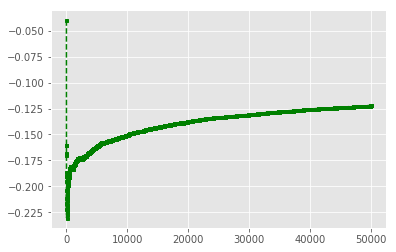

In [82]:
plotLearningCurve2(blackjack_env, 50000)

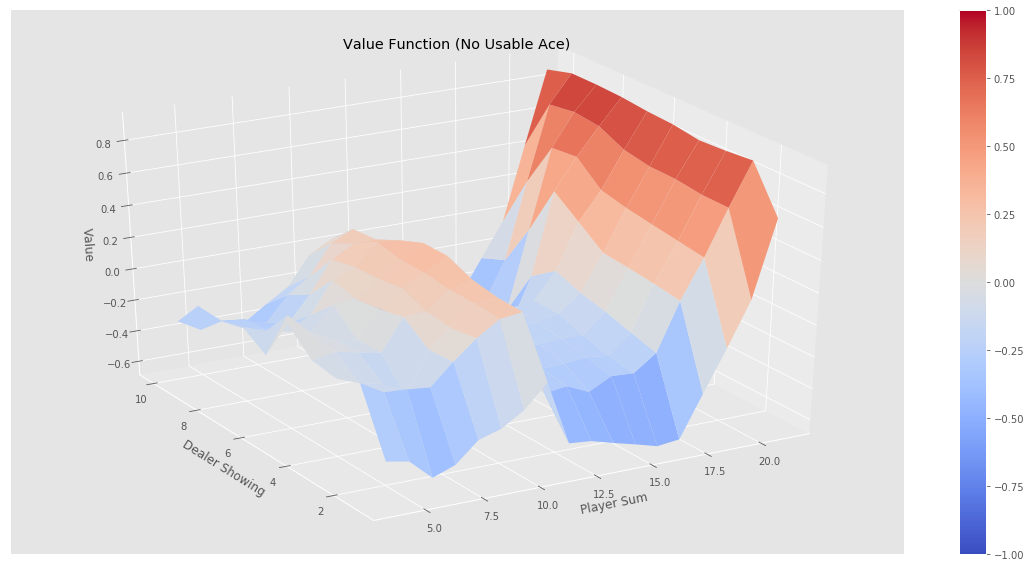

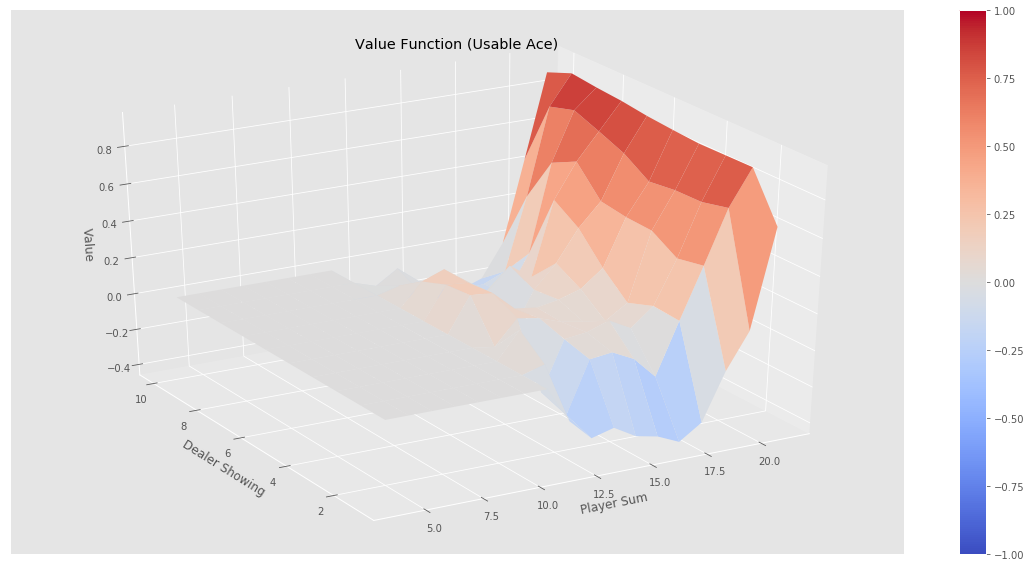

In [66]:
V = defaultdict(float)
Q_func,episode_rewards=train_mc_agent_importance_sampling(blackjack_env, 500000, eps=0.1, gamma=1.0, alpha=0.002, logging=False)
for state, actions in Q_func.items():
    action_value = np.max(actions)
    V[state] = action_value
# plotting.plot_value_function(V, title="Optimal Value Function")
plot_value_function(V, title="Value Function")

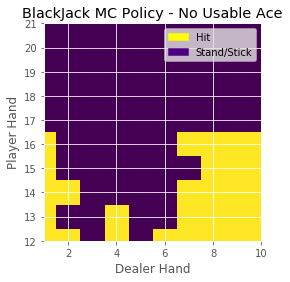

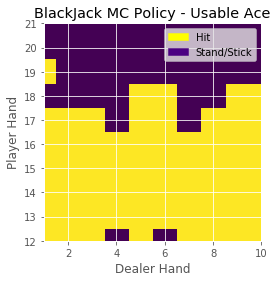

In [67]:
Q_func,episode_rewards=train_mc_agent_importance_sampling(blackjack_env, 500000, eps=0.1, gamma=1.0, alpha=0.002, logging=False)
plotPolicy(Q_func)